In [94]:
%pylab inline
import re
import numpy as np
from collections import Counter, OrderedDict
from itertools import groupby
from datetime import datetime, timedelta
import sys 
sys.path.append('/Users/finkcr1/git/minerva/apl_code/py')
from utils import *
from process_tags import partition_graph
import networkx as nx
from scipy.stats import entropy
import pandas as pd
from statsmodels.formula.api import ols

Populating the interactive namespace from numpy and matplotlib


/Users/finkcr1/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'f', 'yticks', 'datetime', 'xticks']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Read in tweets 
all_tweets = []
with open('syn_undir_dat_try1.csv','r') as f:
    for i, l in enumerate(f):
        if i == 0:
            continue
        cols = l.rstrip('\n').split(',')
        all_tweets.append([int(cols[0]), datetime.utcfromtimestamp(int(cols[0]))] + cols[1:] + 
                          [re.search('(?<=dom_)([0-9]+)',cols[4]).group(1)])

In [3]:
ts = np.array([[x[0], len(x[1])] for x in bin_timeseries([x[1] for x in all_tweets], 6*3600)])
midnights = [p[0] for p in ts if p[0].hour == 0 and p[0].minute == 0]

/Users/finkcr1/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


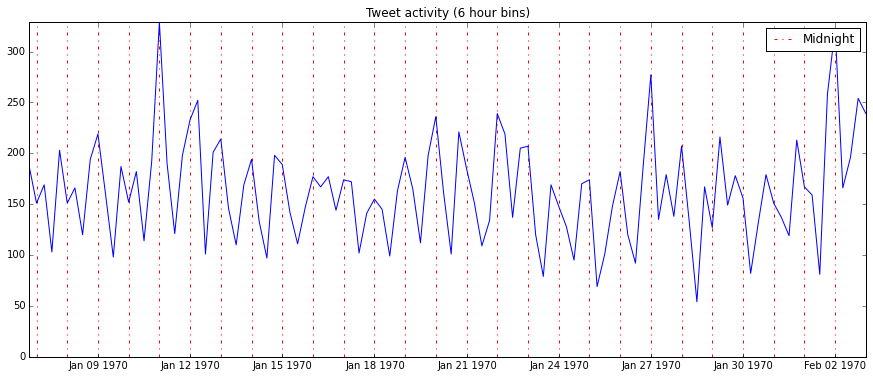

In [4]:
fig = plt.figure()
fig.set_size_inches(15, 6)
plt.title('Tweet activity (6 hour bins)')
plt.plot(ts[:,0], ts[:,1])
plt.vlines(midnights, 0, ts[:,1].max(), color='red', linestyle='-.', label='Midnight')
plt.ylim(0, ts[:,1].max())
plt.legend()

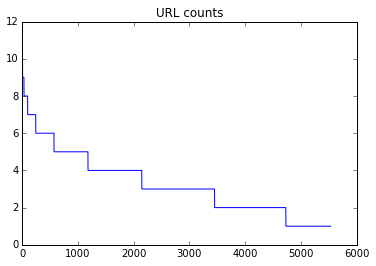

In [5]:
url_counts = Counter([x[5] for x in all_tweets])
plt.plot(range(len(url_counts)), [x[1] for x in url_counts.most_common()])
plt.title('URL counts')

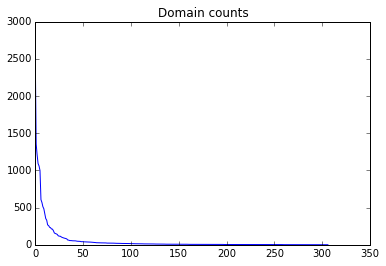

In [6]:
domain_counts = Counter([x[6] for x in all_tweets])
plt.plot(range(len(domain_counts)), [x[1] for x in domain_counts.most_common()])
plt.title('Domain counts')

In [7]:
domain_counts.most_common()[:10]

[('571', 2594),
 ('1039', 1355),
 ('44', 1207),
 ('2147', 1091),
 ('1118', 1060),
 ('2769', 998),
 ('1304', 607),
 ('1147', 570),
 ('938', 513),
 ('694', 485)]

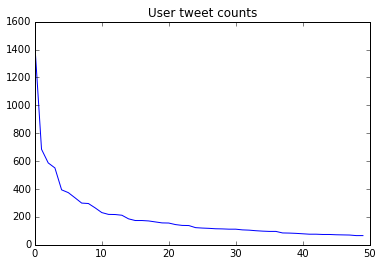

In [8]:
user_counts = Counter([x[3] for x in all_tweets])
plt.plot(range(50), [x[1] for x in user_counts.most_common()[:50]])
plt.title('User tweet counts')

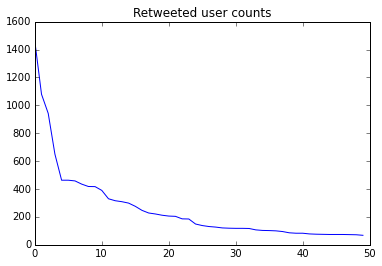

In [9]:
retweeted_user_counts = Counter([x[4] for x in all_tweets])
plt.plot(range(50), [x[1] for x in retweeted_user_counts.most_common()[:50]])
plt.title('Retweeted user counts')

In [81]:
p95 = np.percentile(retweeted_user_counts.values(), 95)
top_retweeted = [x for x in retweeted_user_counts.most_common() if x[1] > p95 and x[0] in user_counts]
top_retweeted

[('17051', 942),
 ('14648', 650),
 ('19612', 418),
 ('31920', 417),
 ('23118', 316),
 ('1514', 299),
 ('10230', 276),
 ('16715', 212),
 ('30756', 185),
 ('1996', 138),
 ('16933', 107),
 ('26877', 103),
 ('32596', 102),
 ('32201', 86),
 ('17334', 76),
 ('21258', 75),
 ('29991', 58)]

In [116]:
segments = sorted(list({x[2] for x in all_tweets}), key=lambda y: int(y.split('_')[1]) if y != 'seg_Nan' else -1)
seg_indices = OrderedDict([[x,y] for x, y in zip(segments, range(len(segments)))])
rev_seg_indicies = {x[1]:x[0] for x in seg_indices.items()}
seg_links = np.zeros((len(segments), len(segments)))
seg_link_counts = np.zeros((len(segments), len(segments)))
user_seg = {x[3]:x[2] for x in all_tweets}
for k, v in groupby(sorted(all_tweets, key=lambda x: x[2]), lambda x: x[2]):
    seg_counts = Counter()
    for x in list(v):
        if x[4] not in user_seg:
            continue
        seg_counts.update([user_seg[x[4]]])
    for x in seg_counts.items():
        if seg_indices[k] == seg_indices[x[0]]:
            continue
        #if seg_links[seg_indices[k],seg_indices[x[0]]] == 0:
        seg_links[seg_indices[k],seg_indices[x[0]]] = 1
        seg_link_counts[seg_indices[k],seg_indices[x[0]]] += x[1]

In [120]:
seg_stats = np.zeros((len(segments), 2))
for k, v in groupby(sorted(all_tweets, key=lambda x: x[2]), lambda x: x[2]):
    tweets = list(v)
    seg_stats[[seg_indices[k]], 0] = len(tweets)
    seg_stats[[seg_indices[k]], 1] = len({x[3] for x in tweets})

In [121]:
init_segments = np.zeros((len(segments),))
for k, v in groupby(sorted(all_tweets, key=lambda x: (x[5], x[0])), lambda x: x[5]):
    tweets = list(v)
    if len(tweets) < 5:
        continue
    init_tweet = tweets[0]
    init_segments[seg_indices[init_tweet[2]]] += 1

In [122]:
init_domain_segments = np.zeros((len(segments),))
for k, v in groupby(sorted(all_tweets, key=lambda x: (x[6], x[0])), lambda x: x[6]):
    tweets = list(v)
    if len(tweets) < 50:
        continue
    init_tweet = tweets[0]
    init_domain_segments[seg_indices[init_tweet[2]]] += 1

In [132]:
seg_entropy = np.zeros((len(segments)))
for i in range(seg_links.shape[0]):
    seg_entropy[i] = entropy(seg_links[i,:]) if seg_links[i,:].sum() > 0 else 0

In [133]:
domains = {x[6] for x in all_tweets}
domain_indices = {x:y for x, y in zip(domains, range(len(domains)))}
seg_domains = np.zeros((len(segments), len(domains)))
for k, v in groupby(sorted(all_tweets, key=lambda x: x[2]), lambda x: x[2]):
    for x in Counter([x[6] for x in list(v)]).items():
        seg_domains[seg_indices[k], domain_indices[x[0]]] = x[1]
seg_domain_focus = [entropy(x) if x.sum() > 0 else 0 for x in seg_domains]

In [125]:
pct_top_retweeted = np.zeros((len(segments,)))
top_retweeted_set = {x[0] for x in top_retweeted}
for k, v in groupby(sorted(all_tweets, key=lambda x: x[2]), lambda x: x[2]):
    tweets = list(v)
    pct_top_retweeted[seg_indices[k]] = len({x[3] for x in tweets if x[3] in top_retweeted_set})/float(len(top_retweeted))

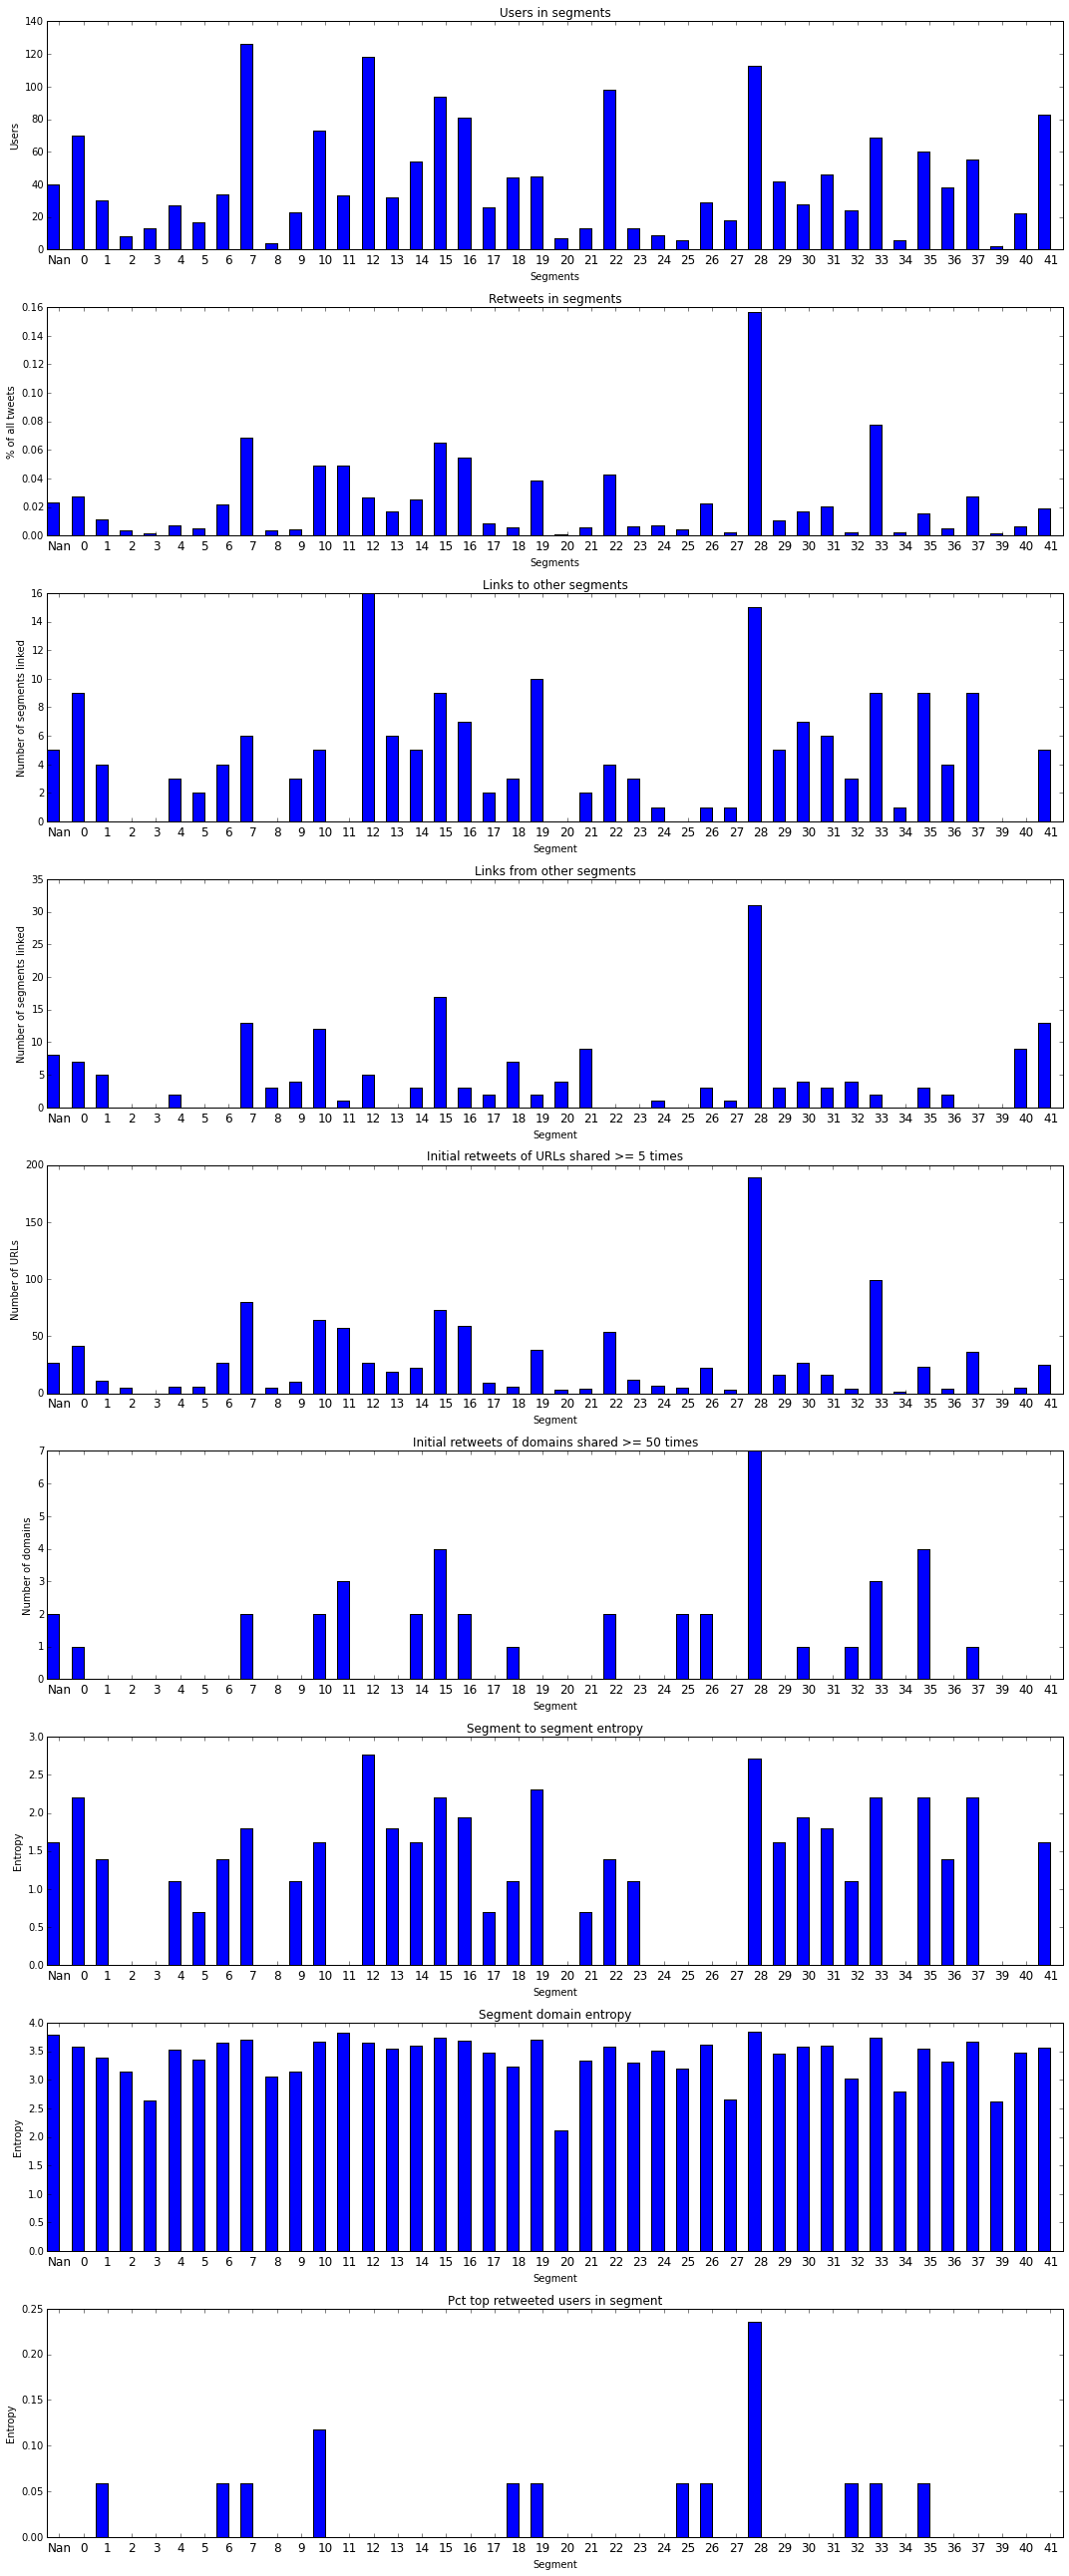

In [134]:
num_plots = 9

fig = plt.figure()
fig.set_size_inches(15, 4 * num_plots)

x = np.array(range(len(segments)))
labels = map(lambda xx: rev_seg_indicies[xx].split('_')[1], x)

ax = plt.subplot(num_plots, 1, 1)
ax.set_title("Users in segments")
ax.bar(x, seg_stats[:,1], width=.5, color='blue')
xticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel('Segments')
plt.ylabel('Users')
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 2)
ax.set_title("Retweets in segments")
ax.bar(x, seg_stats[:,0]/float(len(all_tweets)), width=.5, color='blue')
xticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel('Segments')
plt.ylabel('% of all tweets')
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 3)
ax.set_title("Links to other segments")
ax.bar(x, np.sum(seg_links, axis=1), width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Number of segments linked")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 4)
ax.set_title("Links from other segments")
ax.bar(x, np.sum(seg_links, axis=0), width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Number of segments linked")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 5)
ax.set_title("Initial retweets of URLs shared >= 5 times")
ax.bar(x, init_segments, width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Number of URLs")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 6)
ax.set_title("Initial retweets of domains shared >= 50 times")
ax.bar(x, init_domain_segments, width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Number of domains")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 7)
ax.set_title("Segment to segment entropy")
ax.bar(x, seg_entropy, width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Entropy")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 8)
ax.set_title("Segment domain entropy")
ax.bar(x, seg_domain_focus, width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Entropy")
plt.xlim(0, x.max())

ax = plt.subplot(num_plots, 1, 9)
ax.set_title("Pct top retweeted users in segment")
ax.bar(x, pct_top_retweeted, width=.5)
yticks = plt.xticks(x + .5, labels, fontsize=12)
plt.xlabel("Segment")
plt.ylabel("Entropy")
plt.xlim(0, x.max())

plt.tight_layout()

In [127]:
seg_domain = []
for k, v in groupby(sorted(all_tweets, key=lambda x: (x[5], x[0])), lambda x: x[5]):
    tweets = list(v)
    seg_domain.append([seg_indices[tweets[0][2]], domain_indices[tweets[0][6]]])
seg_domain = np.array(seg_domain)

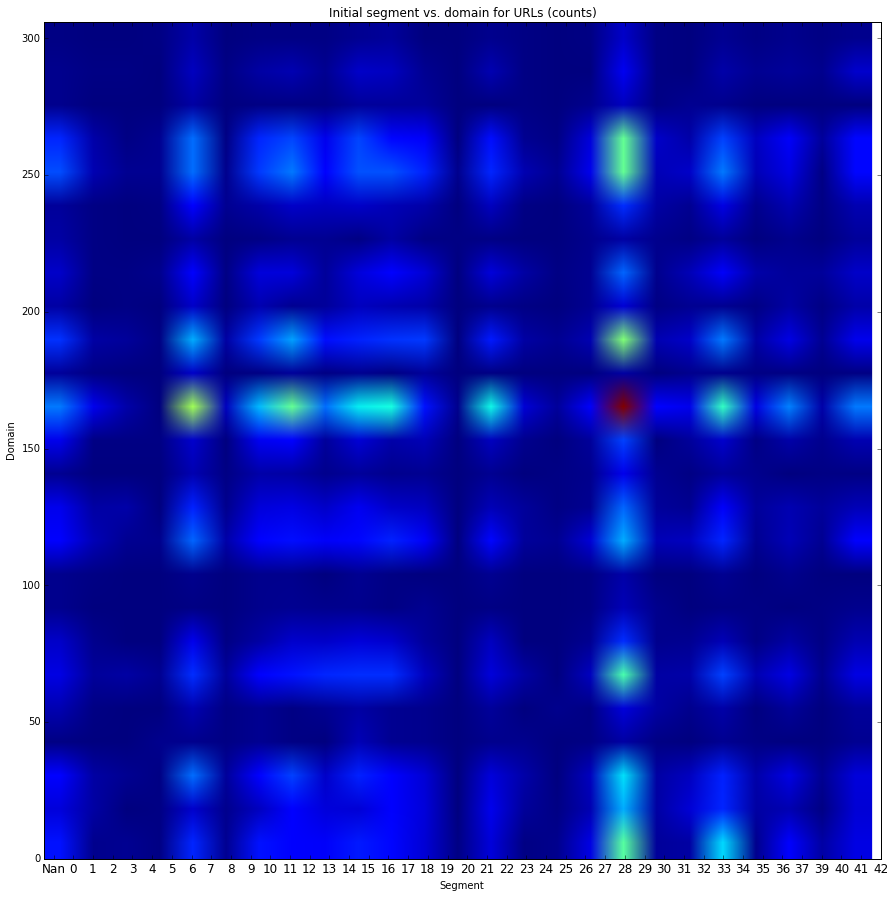

In [128]:

heatmap, xedges, yedges = np.histogram2d(seg_domain[:,0], seg_domain[:,1], bins=25)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


fig = plt.figure()
fig.set_size_inches(15, 15)

plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title('Initial segment vs. domain for URLs (counts)')
plt.xlabel('Segment')
plt.ylabel("Domain")
plt.xlim(0, len(segments) - 1)
yticks = plt.xticks(np.array(range(len(seg_indices))) + .5, labels, fontsize=12)